In [1]:
import json
import re

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from plfit import plfit
from matplotlib import rcParams
from scipy.optimize import curve_fit

# Formato para matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

ModuleNotFoundError: No module named 'plfit'

# Ejercicio 1

## Preliminar

In [3]:
### Cargamos los DataFrames
df_science = pd.read_csv("datasets/netscience_edgelist.txt", delimiter=";", header=None, names=["source", "target", "reference"])
df_science["reference"] = df_science["reference"].apply(lambda x: re.sub("'", "\"", x)) #Movemos a formato de JSON estandar
df_science["reference"] = df_science["reference"].apply(json.loads).apply(pd.Series)    #Cargamos a json y desempaquetamos el dict con el Series.

df_apms = pd.read_csv("datasets/yeast_AP-MS.txt", delimiter="\t", header=None, names=["source", "target"])

df_y2h = pd.read_csv("datasets/yeast_Y2H.txt", delimiter="\t", header=None, names=["source", "target"])

df_internet = pd.read_csv("datasets/as-22july06_edgelist.txt", delimiter=" ", header=None, names=["source", "target", "val"])
df_internet.drop("val", axis=1, inplace=True)

dataframes = { 
    "Science": df_science,
    "Internet": df_internet,
    "AP-MS": df_apms,
    "Y2H": df_y2h,
}

### Creación de grafos
graph_science = nx.from_pandas_edgelist(df_science,"source","target", create_using=nx.Graph())
graph_science_weighted = nx.from_pandas_edgelist(df_science,"source","target", create_using=nx.Graph(), edge_attr = "reference")
weights_science = [i['reference'] for i in dict(graph_science_weighted.edges).values()]

graph_apms = nx.from_pandas_edgelist(df_apms,"source","target", create_using=nx.Graph())

graph_y2h = nx.from_pandas_edgelist(df_y2h,"source","target", create_using=nx.Graph())

graph_internet = nx.from_pandas_edgelist(df_internet,"source","target", create_using=nx.Graph())

dict_graph = { 
    "Science": graph_science,
    "Internet": graph_internet,
    "AP-MS": graph_apms,
    "Y2H": graph_y2h,
}

## Distribución de grado de cada red

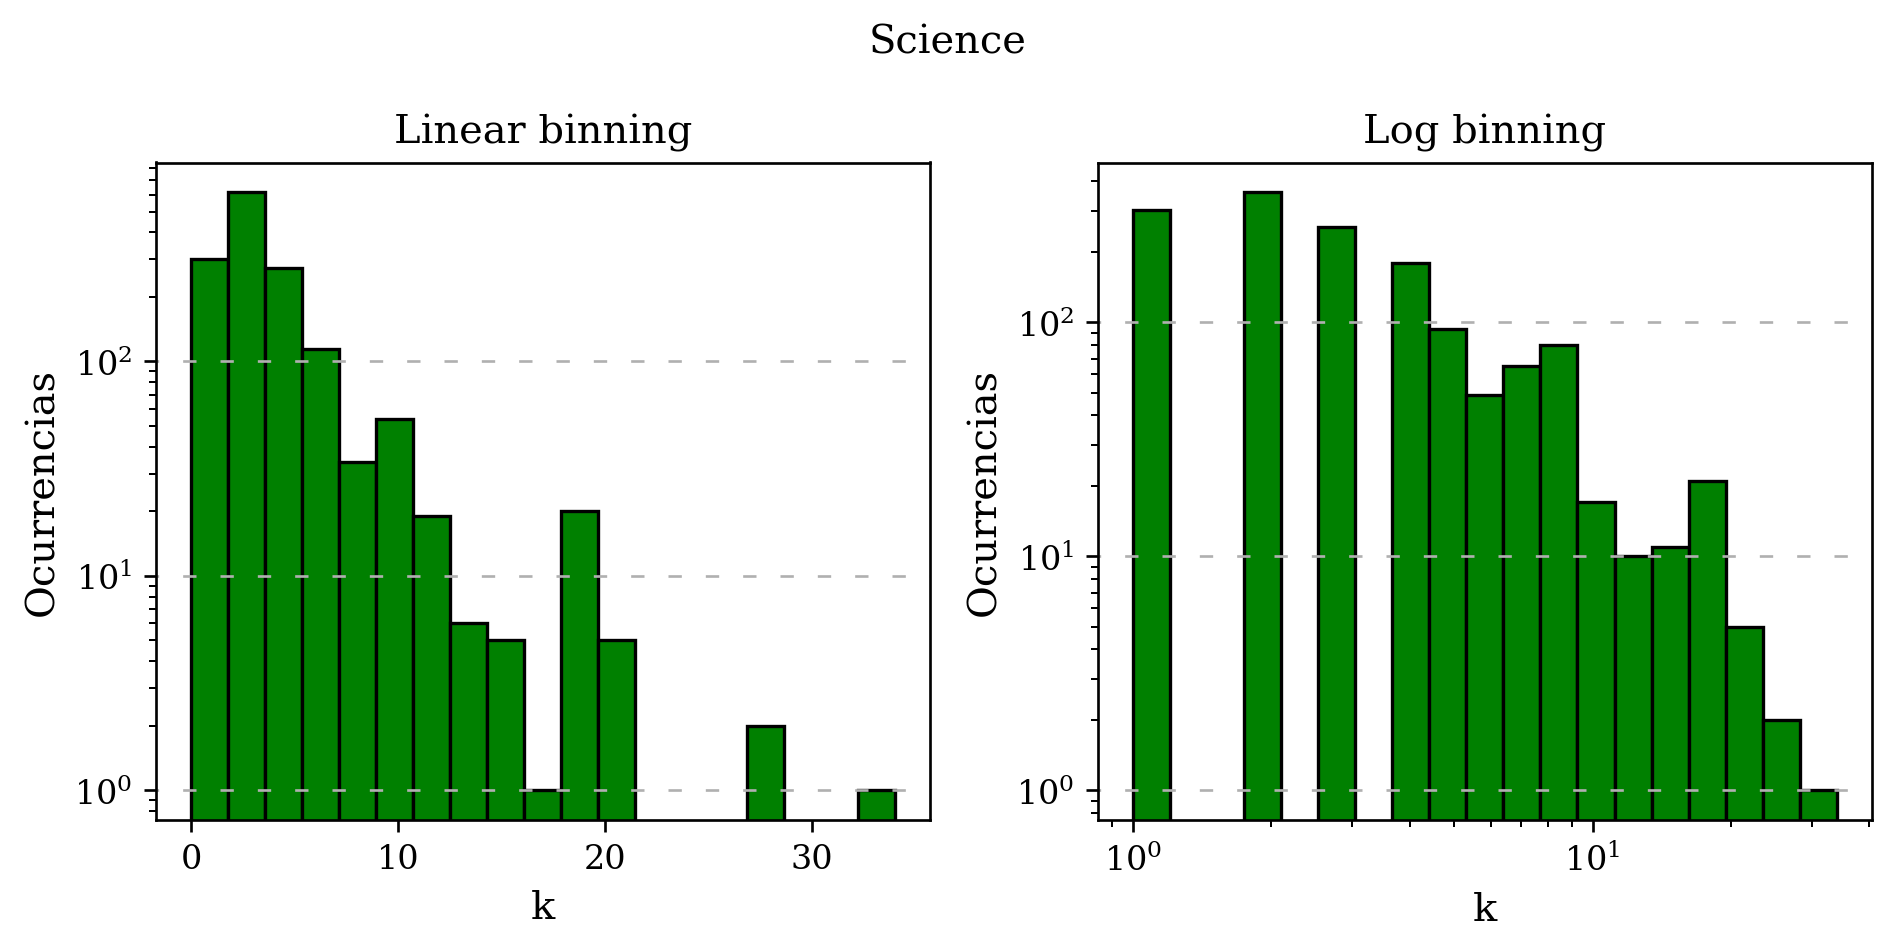

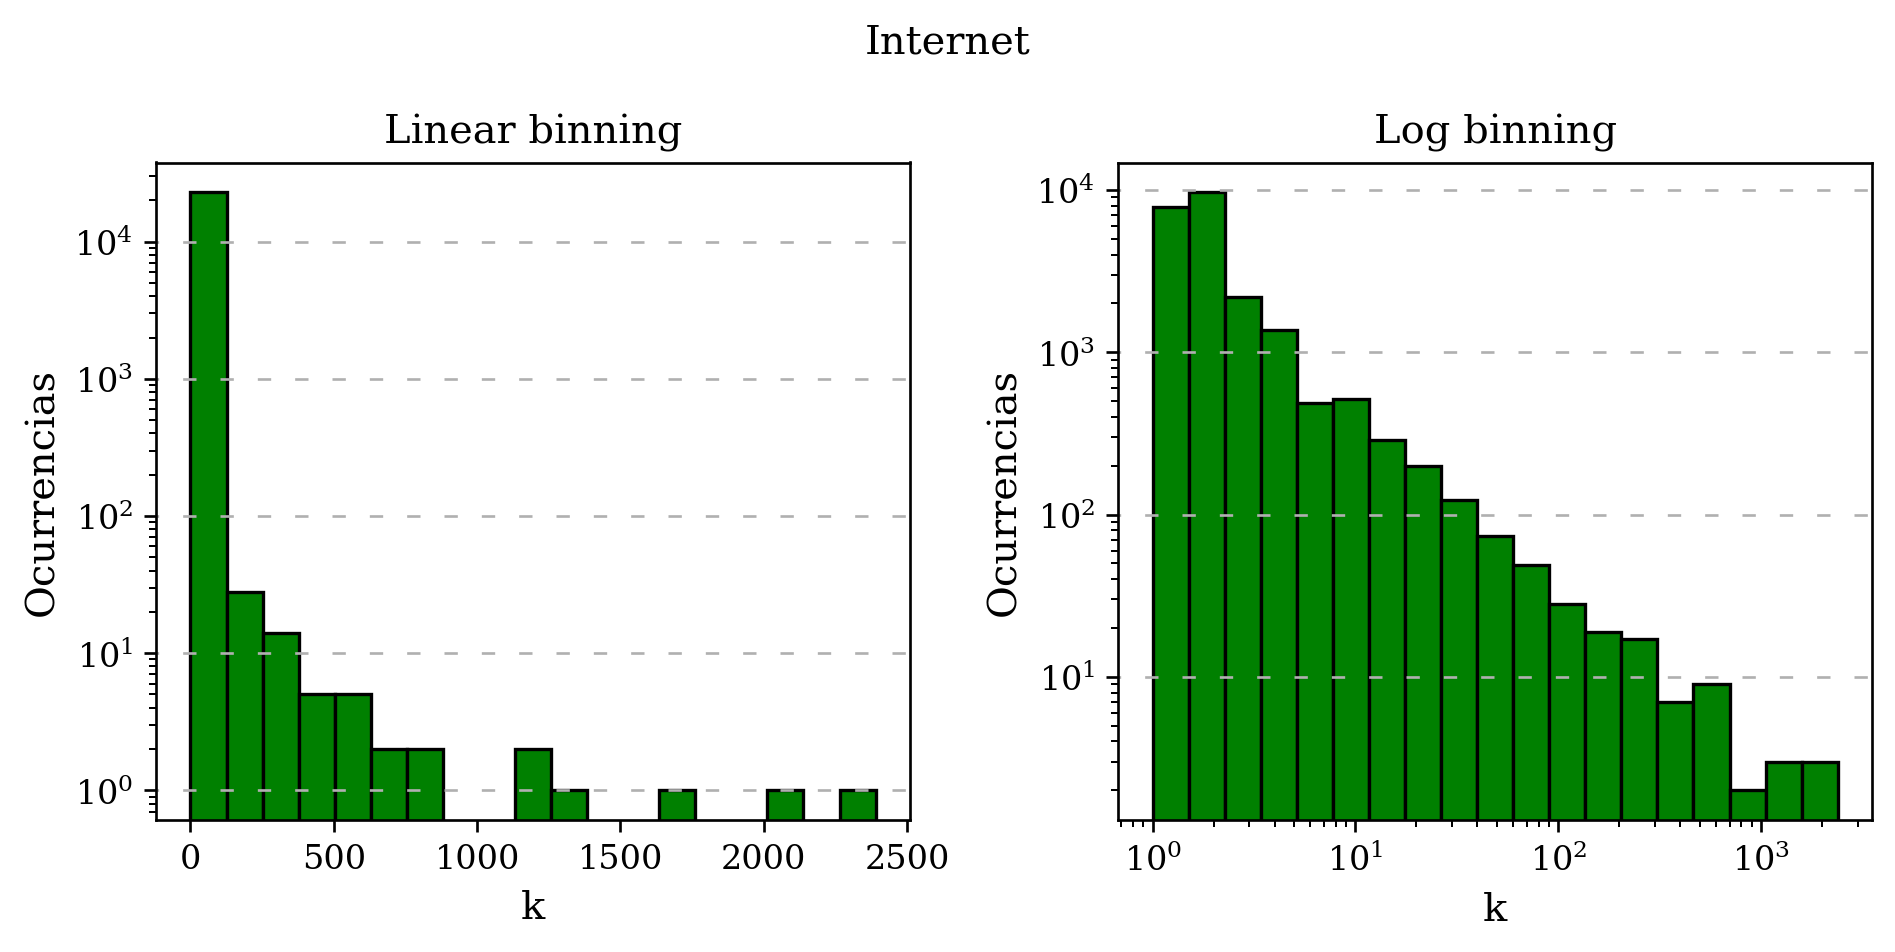

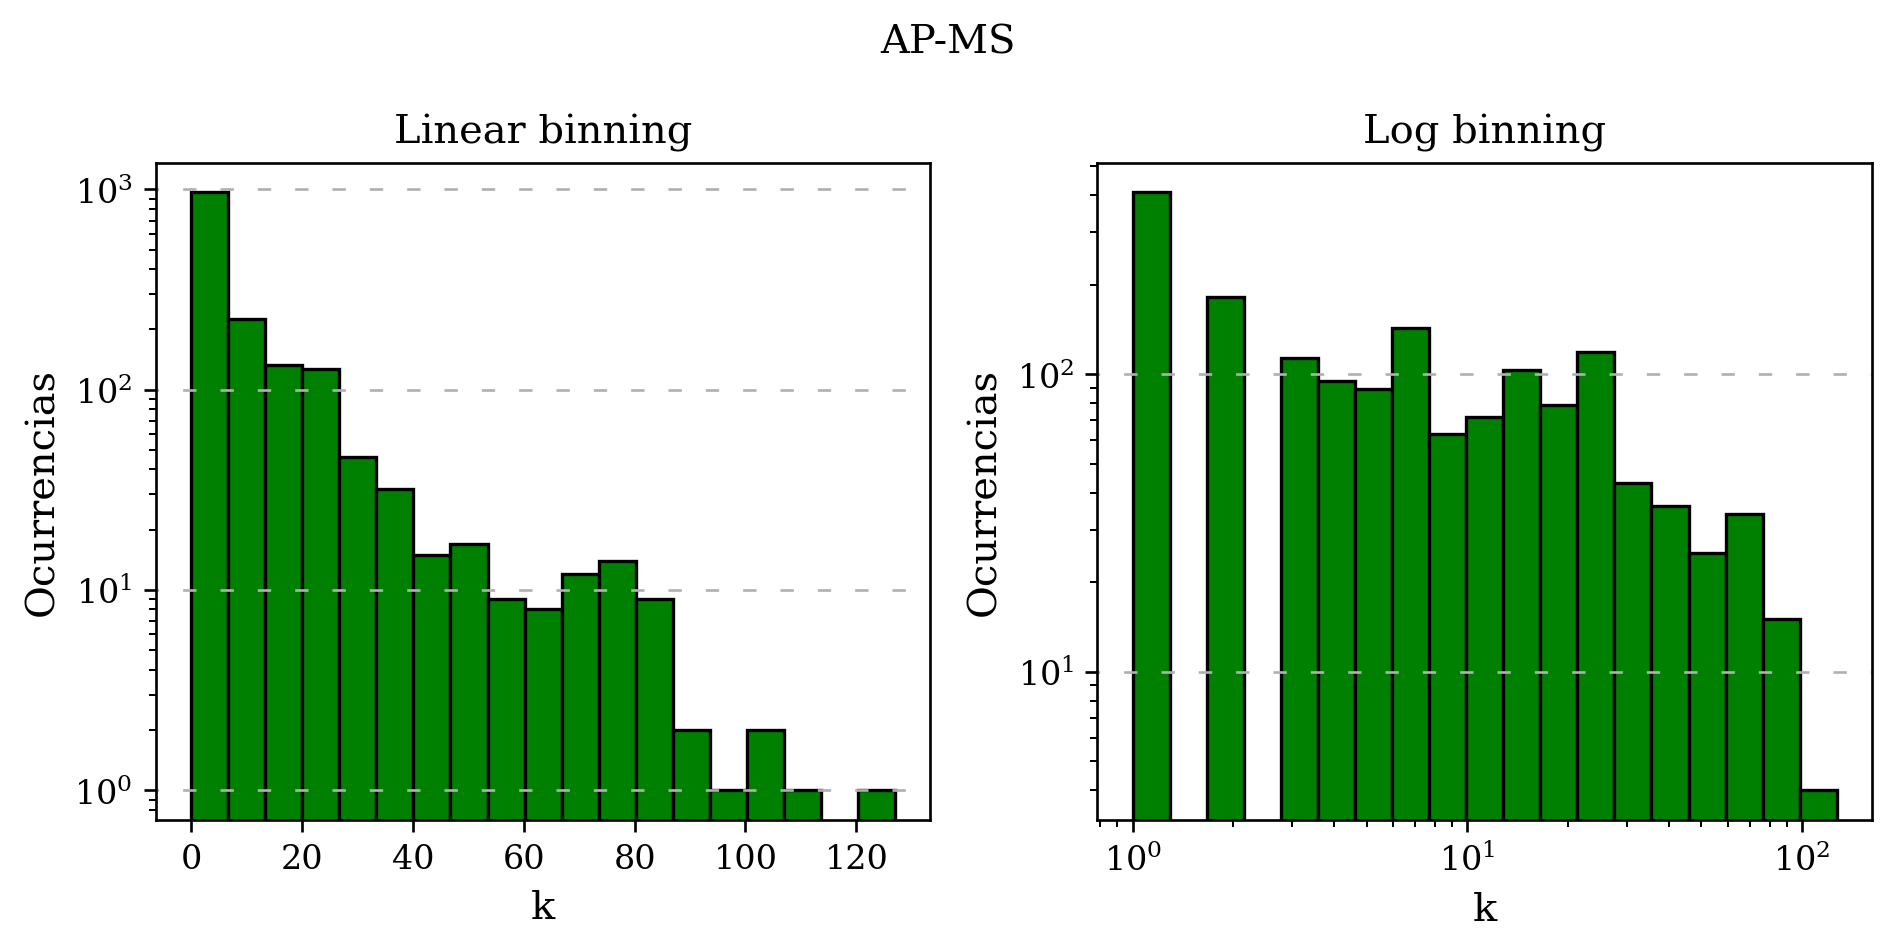

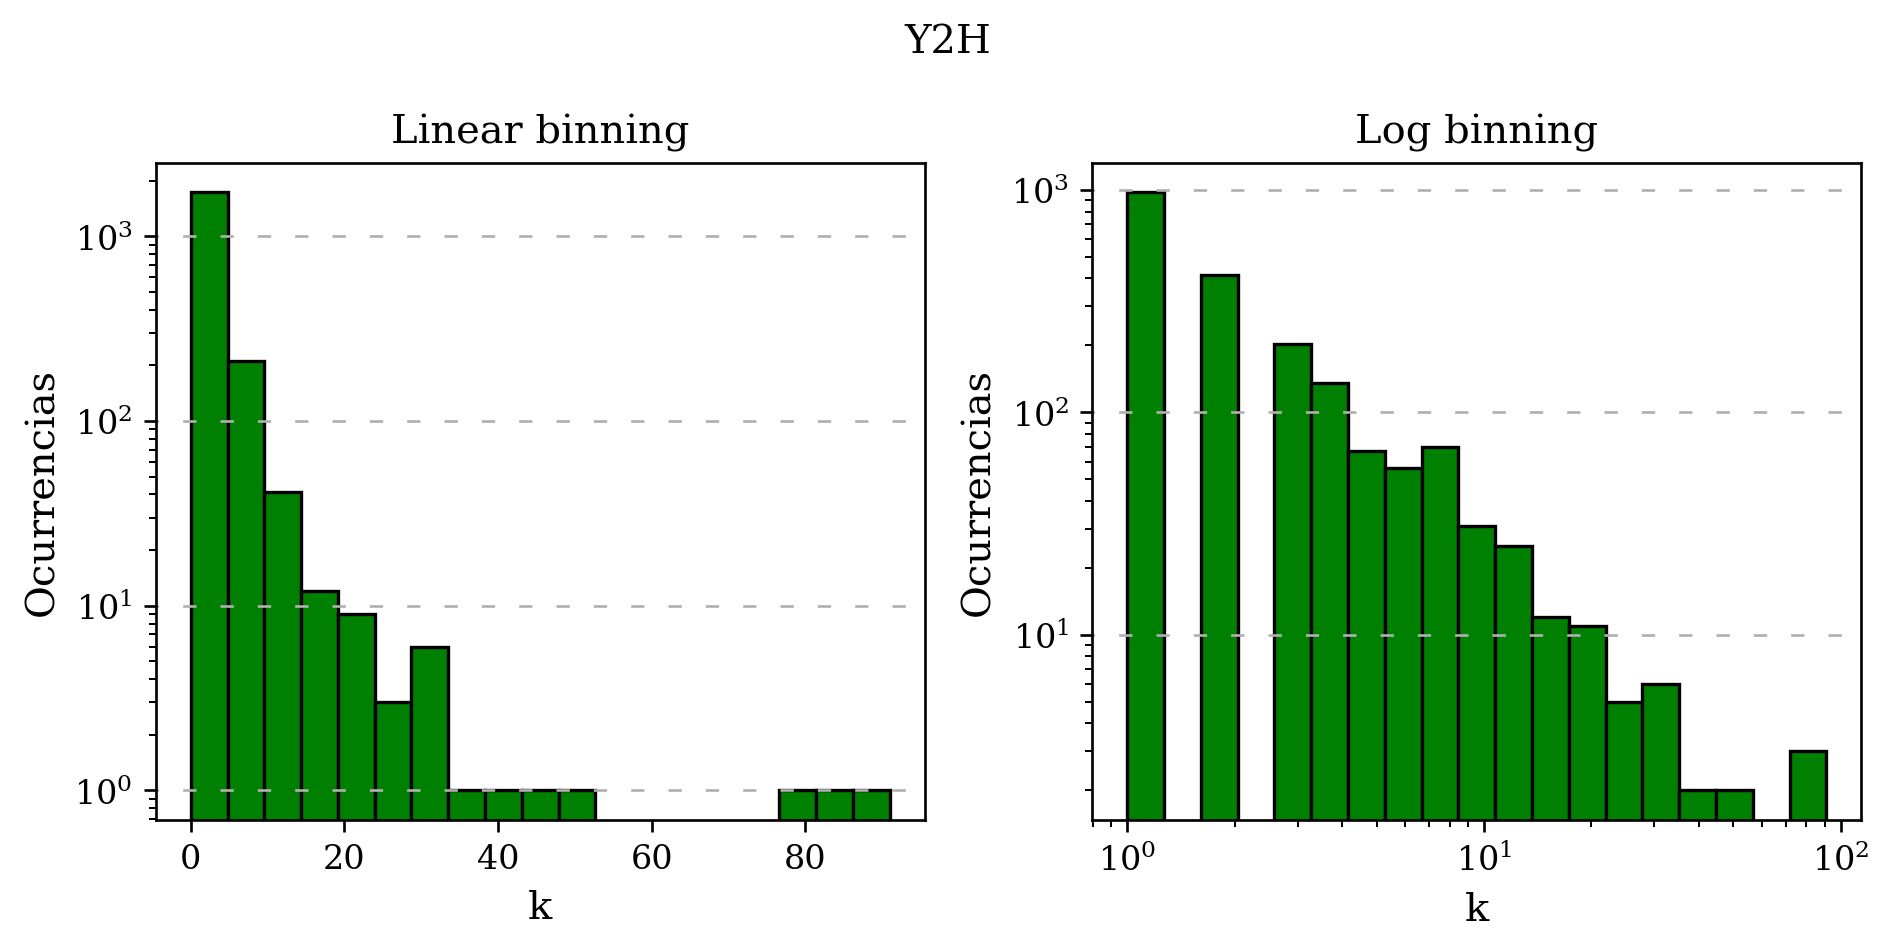

In [21]:
def plot_degree_hist(graph: nx.Graph, title: str, bins: int = 20):
    fig, ax = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)

    lista_grados = list(dict(nx.degree(graph)).values())
    lin_bins = np.linspace(0, np.max(lista_grados), bins)
    log_bins = np.geomspace(1, np.max(lista_grados), bins)

    ax[0].hist(lista_grados, bins=lin_bins, edgecolor="black", color="green")
    ax[0].set_yscale("log")
    ax[0].set_xlabel('k')
    ax[0].set_ylabel("Ocurrencias")
    ax[0].set_title("Linear binning")
    ax[0].grid(axis="y", linestyle=(4, (5, 9)))
    
    ax[1].hist(lista_grados, bins=log_bins, edgecolor="black", color="green")
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")
    ax[1].set_xlabel('k')
    ax[1].set_ylabel("Ocurrencias")
    ax[1].set_title("Log binning")
    ax[1].grid(axis="y", linestyle=(4, (5, 9)))
    
    fig.suptitle(title)
    plt.show()
    
for k, g in dict_graph.items():
    plot_degree_hist(g, k)

En primera instancia, antes de realizar los ajustes, pareciera ser que Y2H e Internet son las que mejor se ajustan a una ley de potencias ya que con el bineado logarítmico se observa una tendencia lineal.

Ajustamos por una ley de potencias a cada red para ver los parámetros.

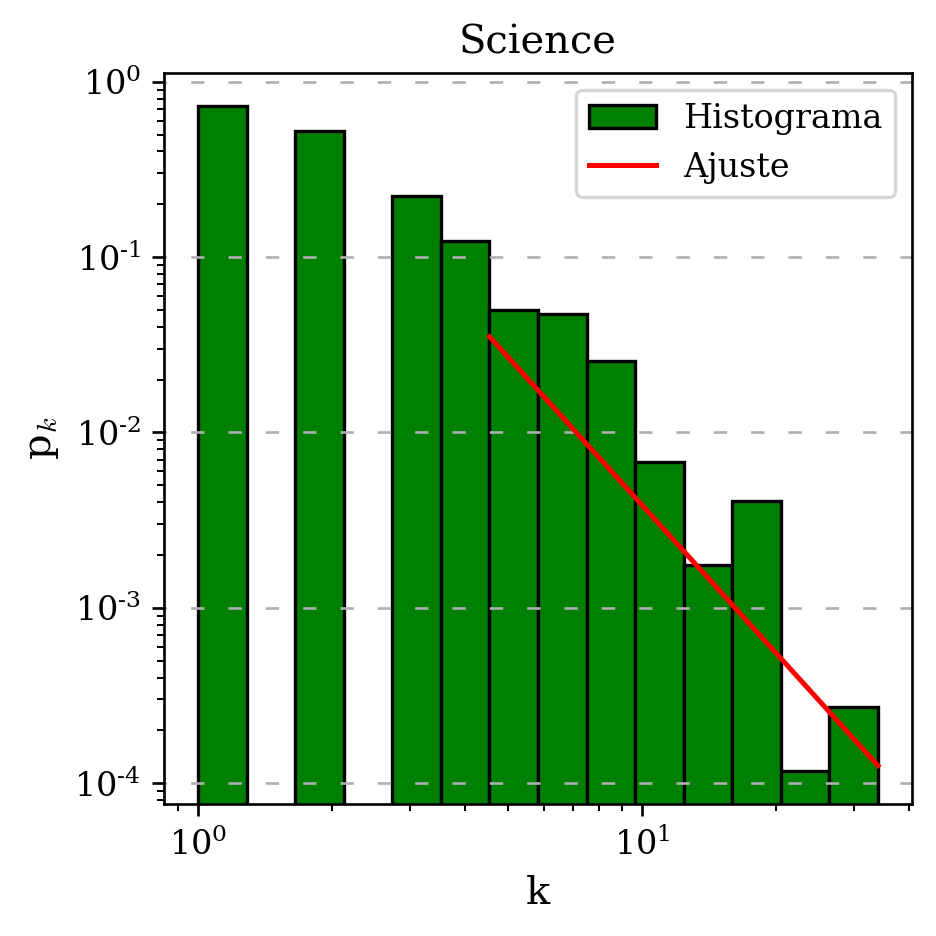

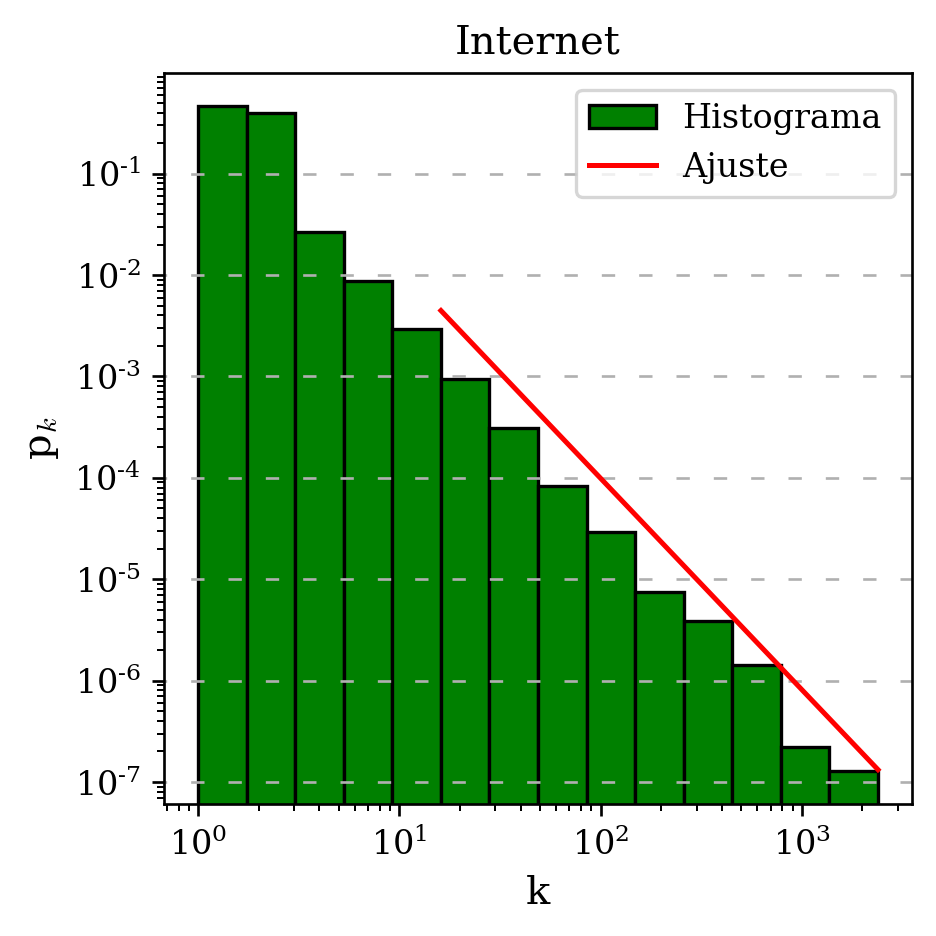

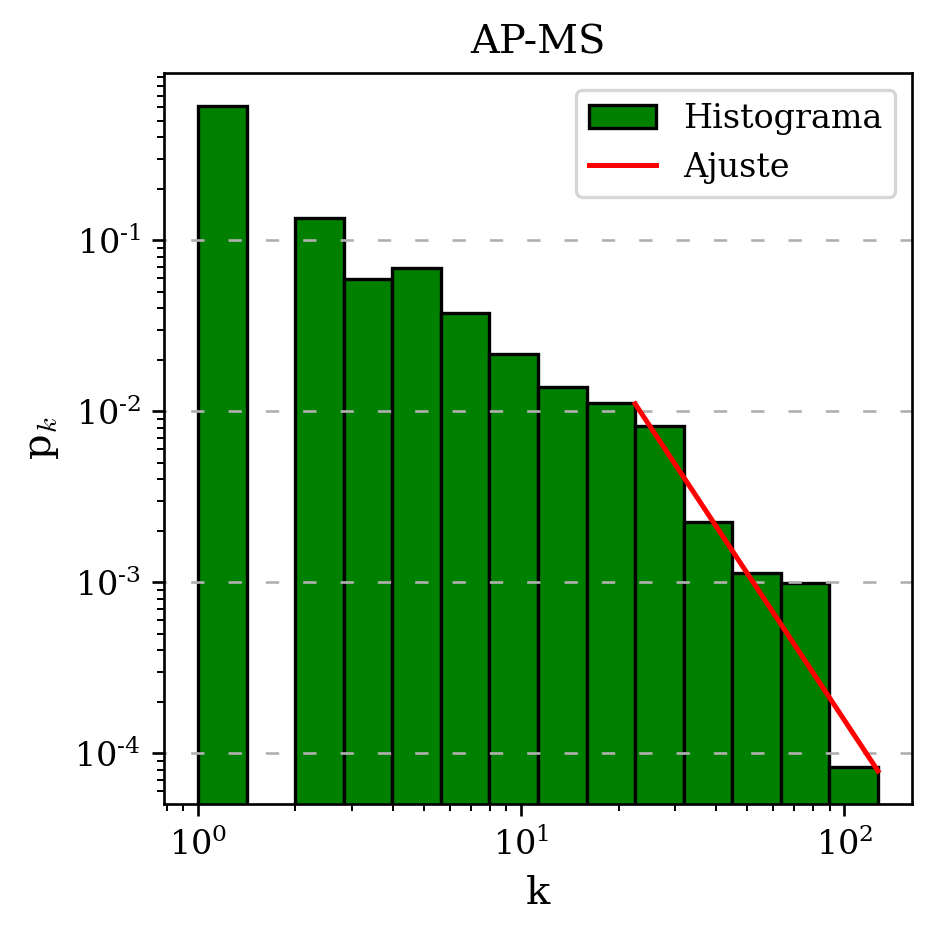

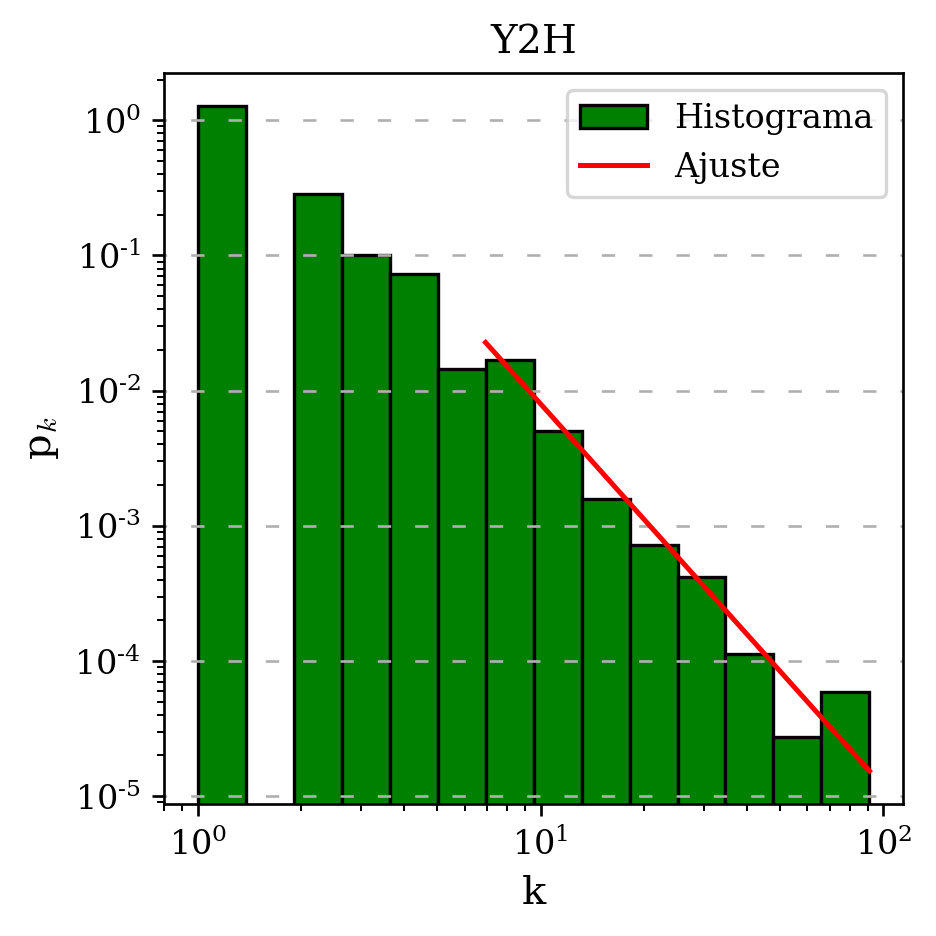

{'Science': {'Kmin': 4, 'gamma': 2.796, 'gamma_err': 0.08, 'k_sat': 0.07},
 'Internet': {'Kmin': 11, 'gamma': 2.085, 'gamma_err': 0.04, 'k_sat': 0.02},
 'AP-MS': {'Kmin': 20, 'gamma': 2.858, 'gamma_err': 0.11, 'k_sat': 0.04},
 'Y2H': {'Kmin': 6, 'gamma': 2.832, 'gamma_err': 0.12, 'k_sat': 0.04}}

In [50]:
def fit_powerlaw(graph: nx.Graph, title: str, PLOT: bool = True, bins: int = 20):

    #Calculo de bins y grados
    lista_grados = list(dict(nx.degree(graph)).values())
    log_bins = np.geomspace(1, np.max(lista_grados), bins)
        
    #Ajuste
    fit = plfit(lista_grados)
    Kmin = fit._xmin #este sería nuestro Kmin
    gamma = round(fit._alpha, 3) #este sería nuestro gamma
    gamma_err = round(fit._alphaerr, 2)
    k_sat = round(fit._ks, 2)
    
    if PLOT:
        #Armado de histograma
        fig, ax = plt.subplots(1, 1, figsize=(4,4), tight_layout=True)
        hist = ax.hist(lista_grados, bins=log_bins, edgecolor="black", color="green", density=True, label="Histograma")
           
        #Gráfico de recta de ajuste
        norm = np.sum(hist[1]>Kmin)
        
        y = ((gamma-1)*Kmin**(gamma-1)*log_bins**-gamma)/norm
        
        ax.plot(log_bins[log_bins>Kmin],y[log_bins>Kmin], color="red", label="Ajuste")

        #Formato
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel('k')
        ax.set_ylabel("p$_k$")
        ax.set_title(title)
        ax.grid(axis="y", linestyle=(4, (5, 9))) 
        ax.legend()

        plt.show()
    
    return {"Kmin": Kmin, "gamma": gamma, "gamma_err": gamma_err, "k_sat": k_sat}

fit_params = {k: fit_powerlaw(g, k, PLOT=True, bins = 15) for k, g in dict_graph.items()}
fit_params

Para ver el efecto de borde de las redes vamos a realizar histogramas utilizando un bineado lineal en escala log-log con $\Delta k=1$.

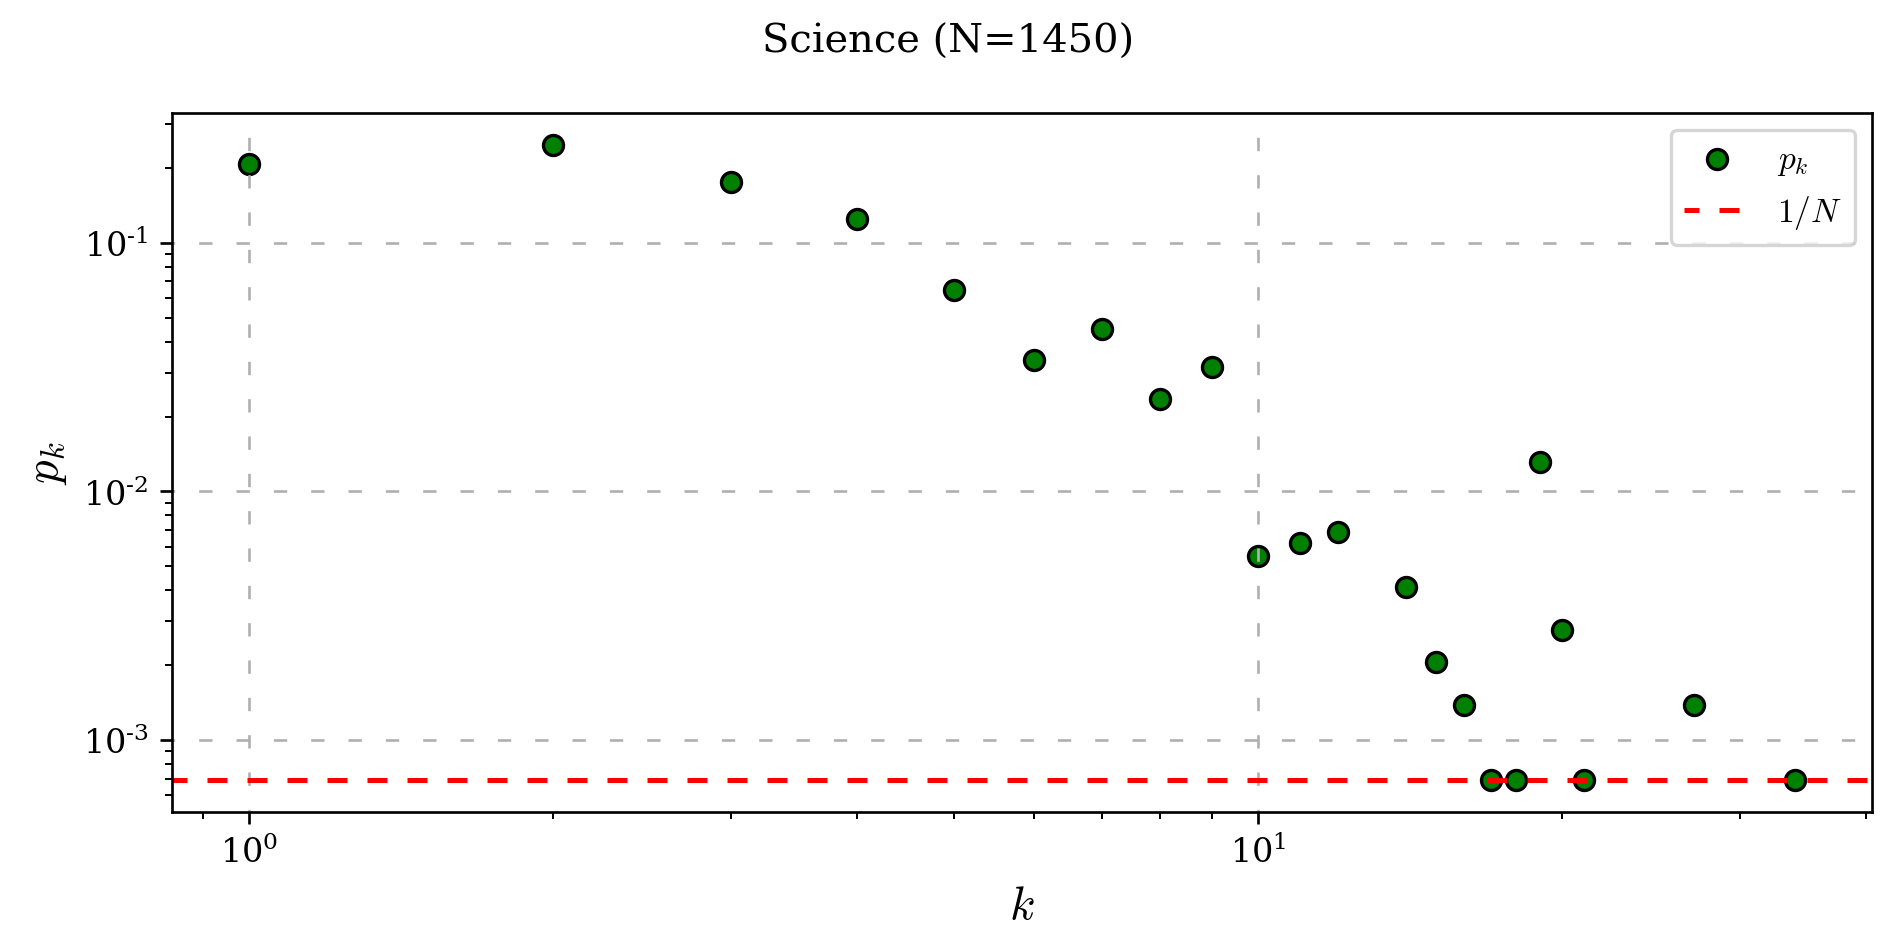

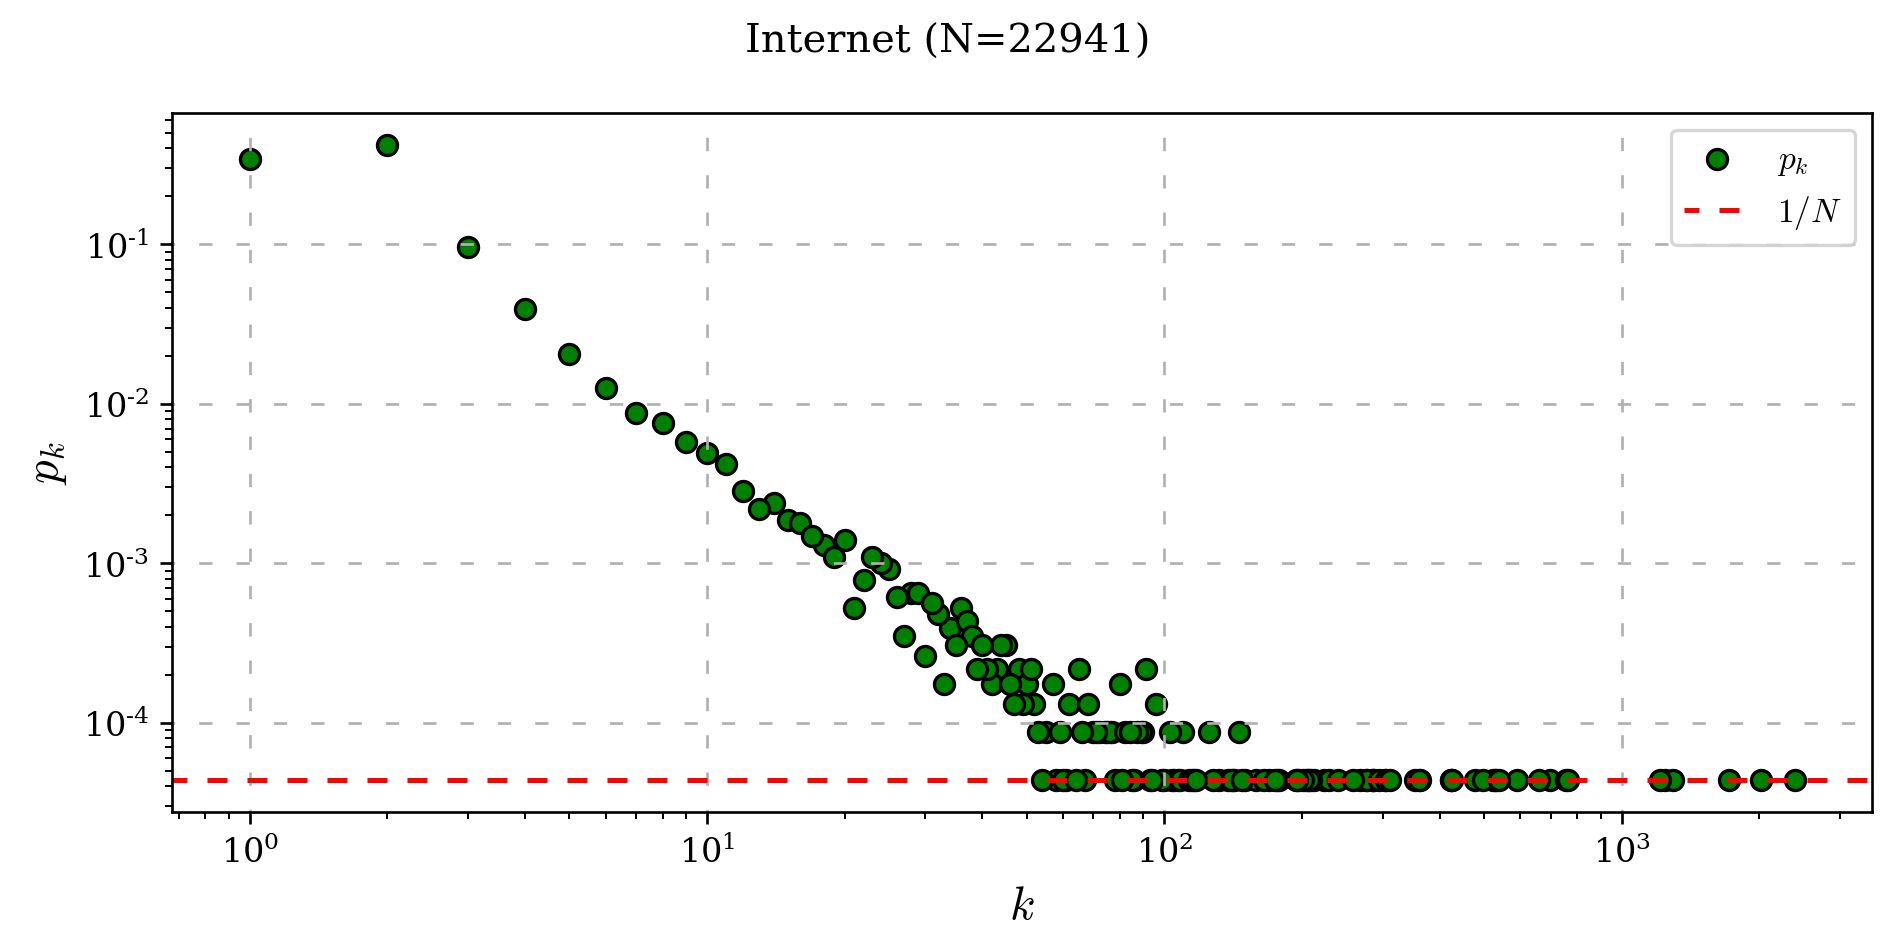

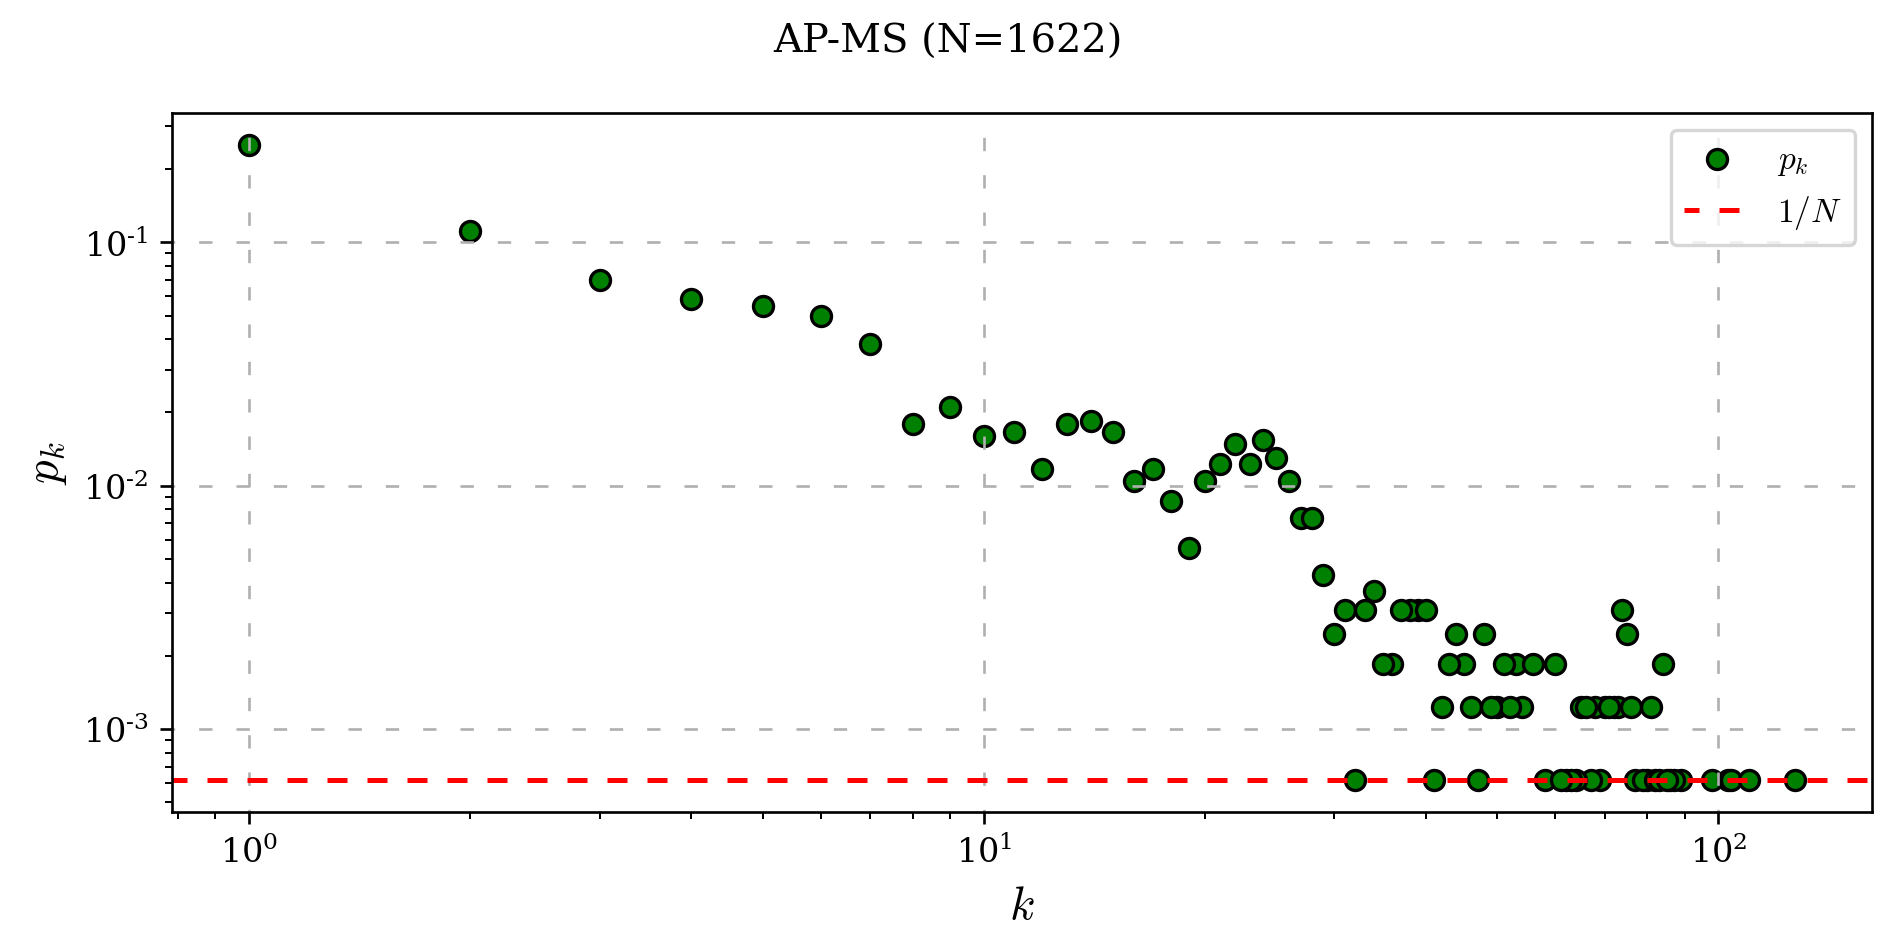

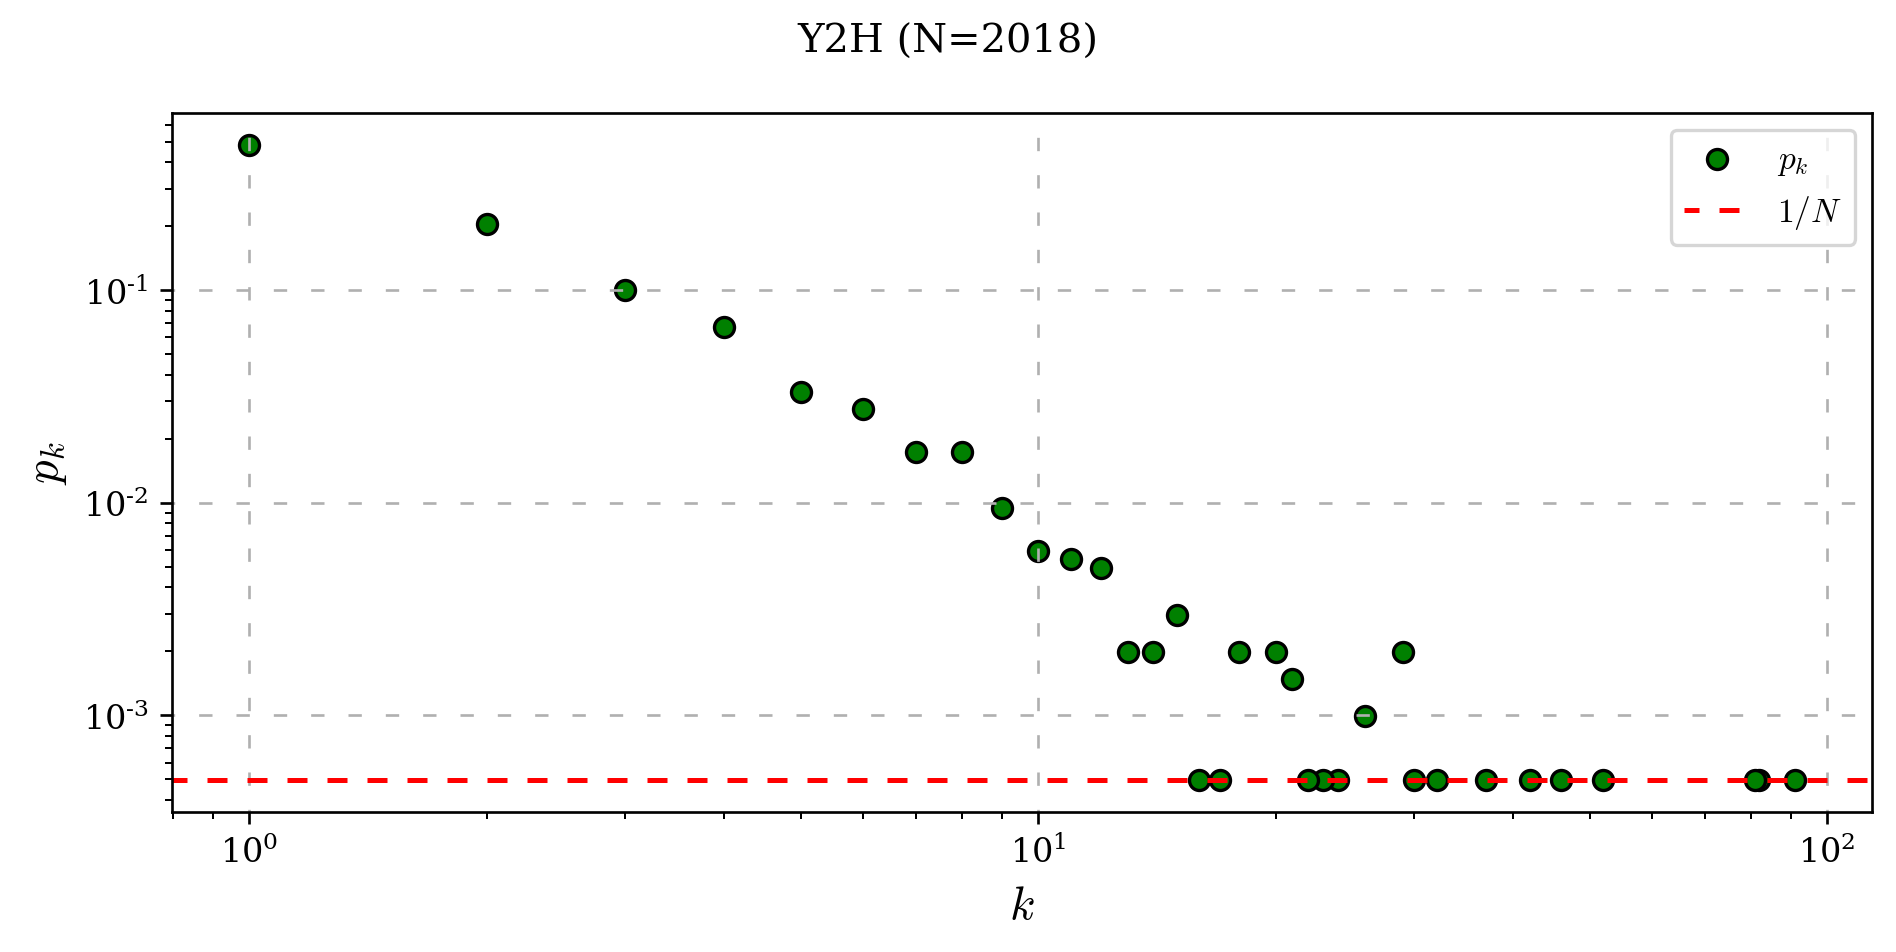

In [48]:
def plot_degree_dist(graph: nx.Graph, title: str, bins: int = 20):
    from collections import Counter, OrderedDict
    
    fig, ax = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)

    lista_grados = list(dict(nx.degree(graph)).values())
    grados_hist = dict(Counter(lista_grados))
    grados_hist_N = {k: v/len(lista_grados) for k, v in grados_hist.items()}
    
    ax.scatter(grados_hist_N.keys(), grados_hist_N.values(),
               color="green", edgecolor="black", label="$\frac{N_k}{N}$")
    ax.axhline(1/len(lista_grados), linestyle=(1, (4, 4)), label ="$1/N$", color ="red")
    
    """
    Kmin = fit_params[title]["Kmin"]
    gamma = fit_params[title]["gamma"]
    
    k = np.array(list(grados_hist_N.keys()))
    
    norm = np.sum(k>=Kmin)
    y = ((gamma-1)*Kmin**(gamma-1)*k**(-gamma))/norm
        
    ax.plot(k[k>Kmin],y[k>Kmin], color="red", label="Ajuste")
    """
    
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel('$k$', fontsize = 14)
    ax.set_ylabel("$p_k$", fontsize = 14)
    ax.grid(linestyle=(4, (5, 9)))
    ax.legend()
        
    fig.suptitle(title + f" (N={len(lista_grados)})")
    plt.show()
    
for k, g in dict_graph.items():
    plot_degree_dist(g, k)

Graficando la distribución de grados (normalizada) con $\Delta k = 1$ podemos observar cómo el tamaño finito de las redes pone una  "cota a la resolución" de la distribución. Es decir, aquellos eventos que suceden una única vez, por más baja probabilidad de suceder que tenga ese evento dado el modelo de ley de potencias, se muestran con probabilidad de $1/N$ dentro de la distribución efectiva de la red.

También es relevante el tamaño de la red. En la red de Science, la cual es relativamente pequeña, se observan tan solo un par de ocurrencias para estos valores de $k$, mientras que las redes más grandes presentan muchas más ocurrencias con frecuencia $1/N$ las cuales resaltan del patrón esperado.

Dicho esto, para las redes cuya distribución de grado se ajusta por una ley de potencias con un mayor $\gamma$ (y cuyas rectas resultan más empinadas), la probabilidad de ver nodos de $k$ alto decrece muy rápidamente, implicando que esta cota en la resolución tiene un efecto en una cantidad pequeña de nodos, y en un rango mucho más acotado que para distribuciones de menor $\gamma$. Estas últimas poseen probabilidades de grado no despreciables para grados altos en varios ordenes de magnitud, haciendo que la cota en resolución afecte a una mayor cantidad de nodos a lo largo de un rango más amplio de valores de $k$.

Así, sumando que la red Internet posee el valor de $\gamma$ más bajo así como el tamaño más grande de todas las redes estudiadas, es en esta donde el efecto de borde producto de su tamaño finito se hace más notable.

# Ejercicio 2

## Análisis de asortatividad

Para ajustar $k_{nn}(k)$ se partió de:
$$k_{nn}(k) = a k^\mu$$
Tomando $log$ de ambos lados:
$$\log(k_{nn}) = \log(a k^\mu)$$
Utilizando propiedades de logaritmo sobre el lado izquierdo de la ecuación:
$$\log(k_{nn}) = \log(a) + \mu \; \log(k)$$
Por lo que renombrando $\alpha = \log(a)$, $\beta = \mu$:
$$\log(k_{nn}) = \alpha + \beta \; \log(k)$$
Es decir, podemos ajustar por una lineal tomando variable independiente $\log(k)$ y variable dependiente $\log(k_{nn})$

Entonces, luego uno puede graficar la función como: $f(k) = e^\alpha \; k^\beta$.
Alternativamente, vamos a ajustar directamente la exponencial para comparar la convergencia de los ajustes.

### Metodo viejo

5454 37932 450186


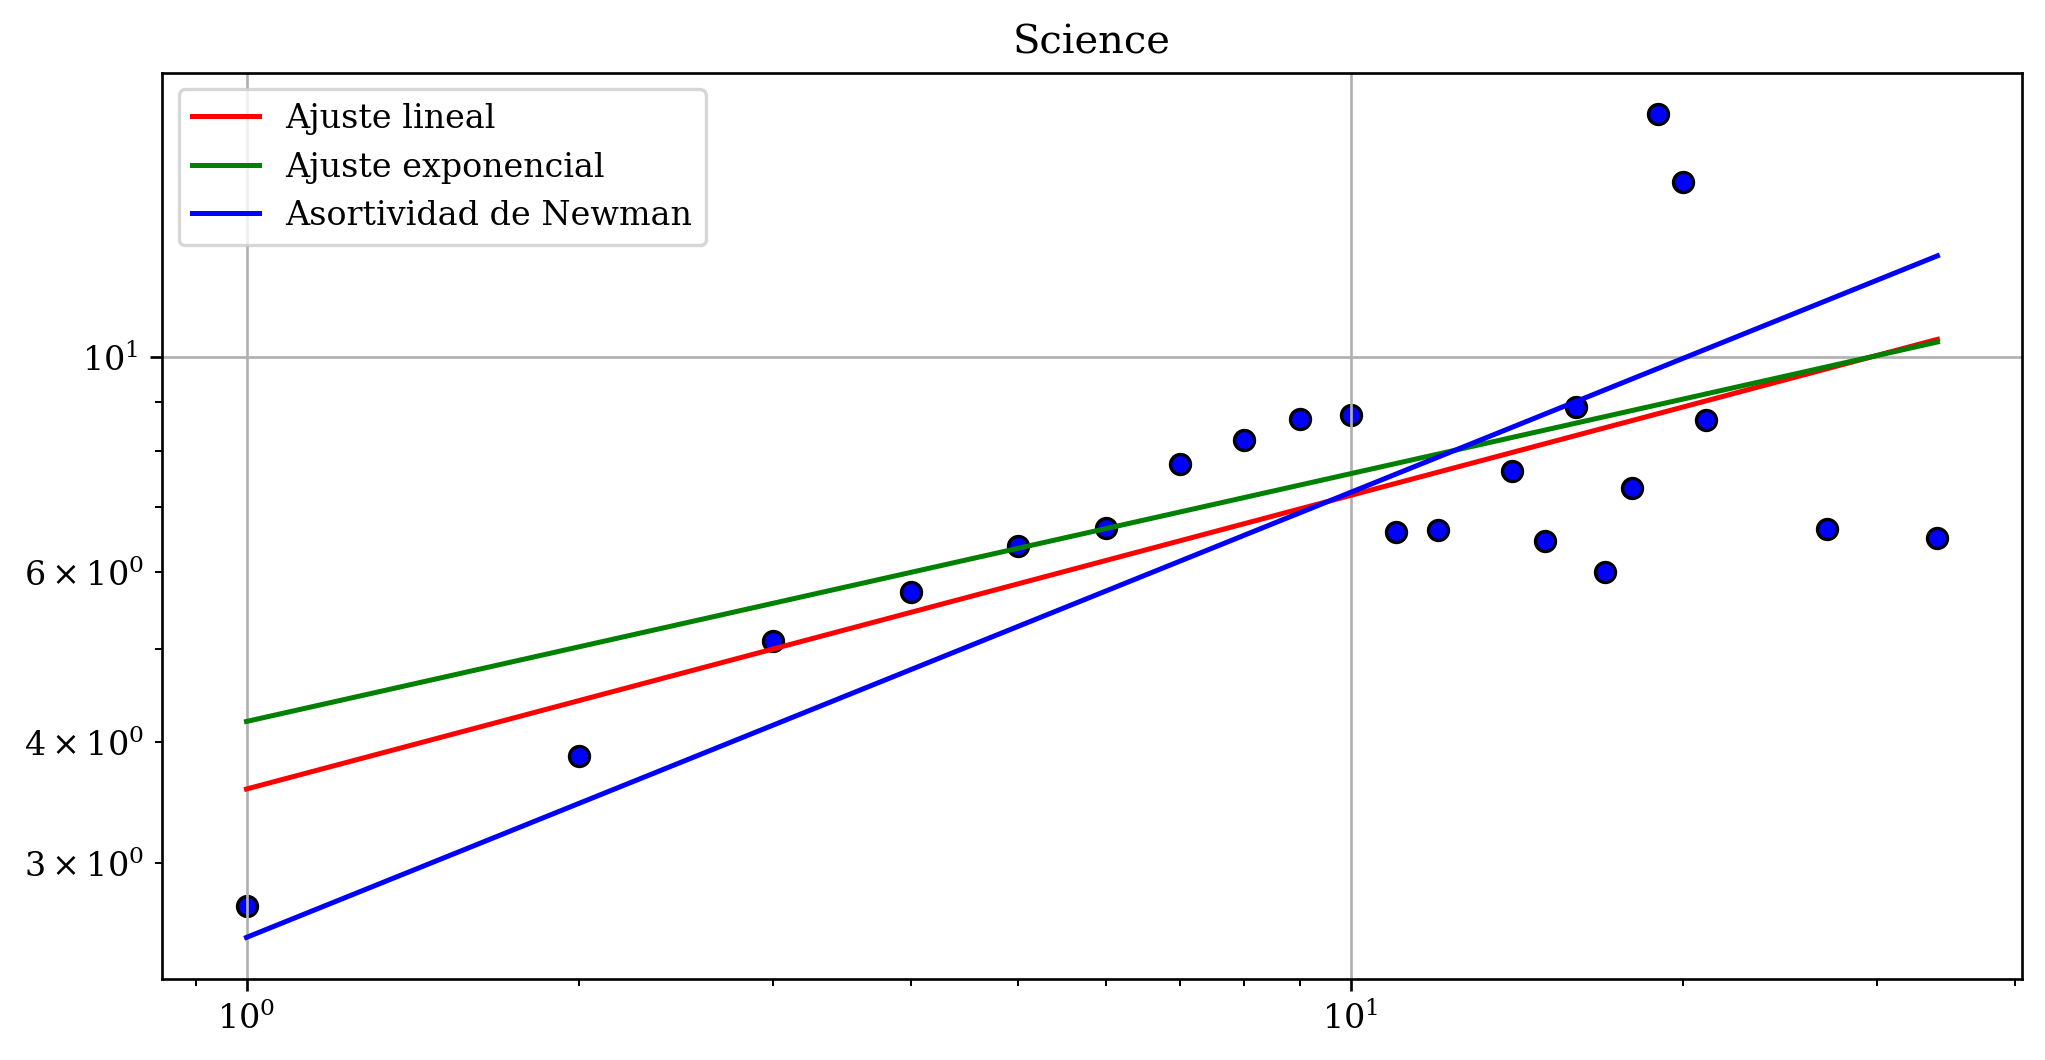

Parámetros óptimos del ajuste para la red 'Science':
            alpha = 0.3032576981086007
            beta = 1.2756455530135336
            a = 4.205283003977264
            mu = 0.25590420123950297
Asortatividad de Newman para la red 'science': 0.4596424819185922


96744 25327698 36151963596


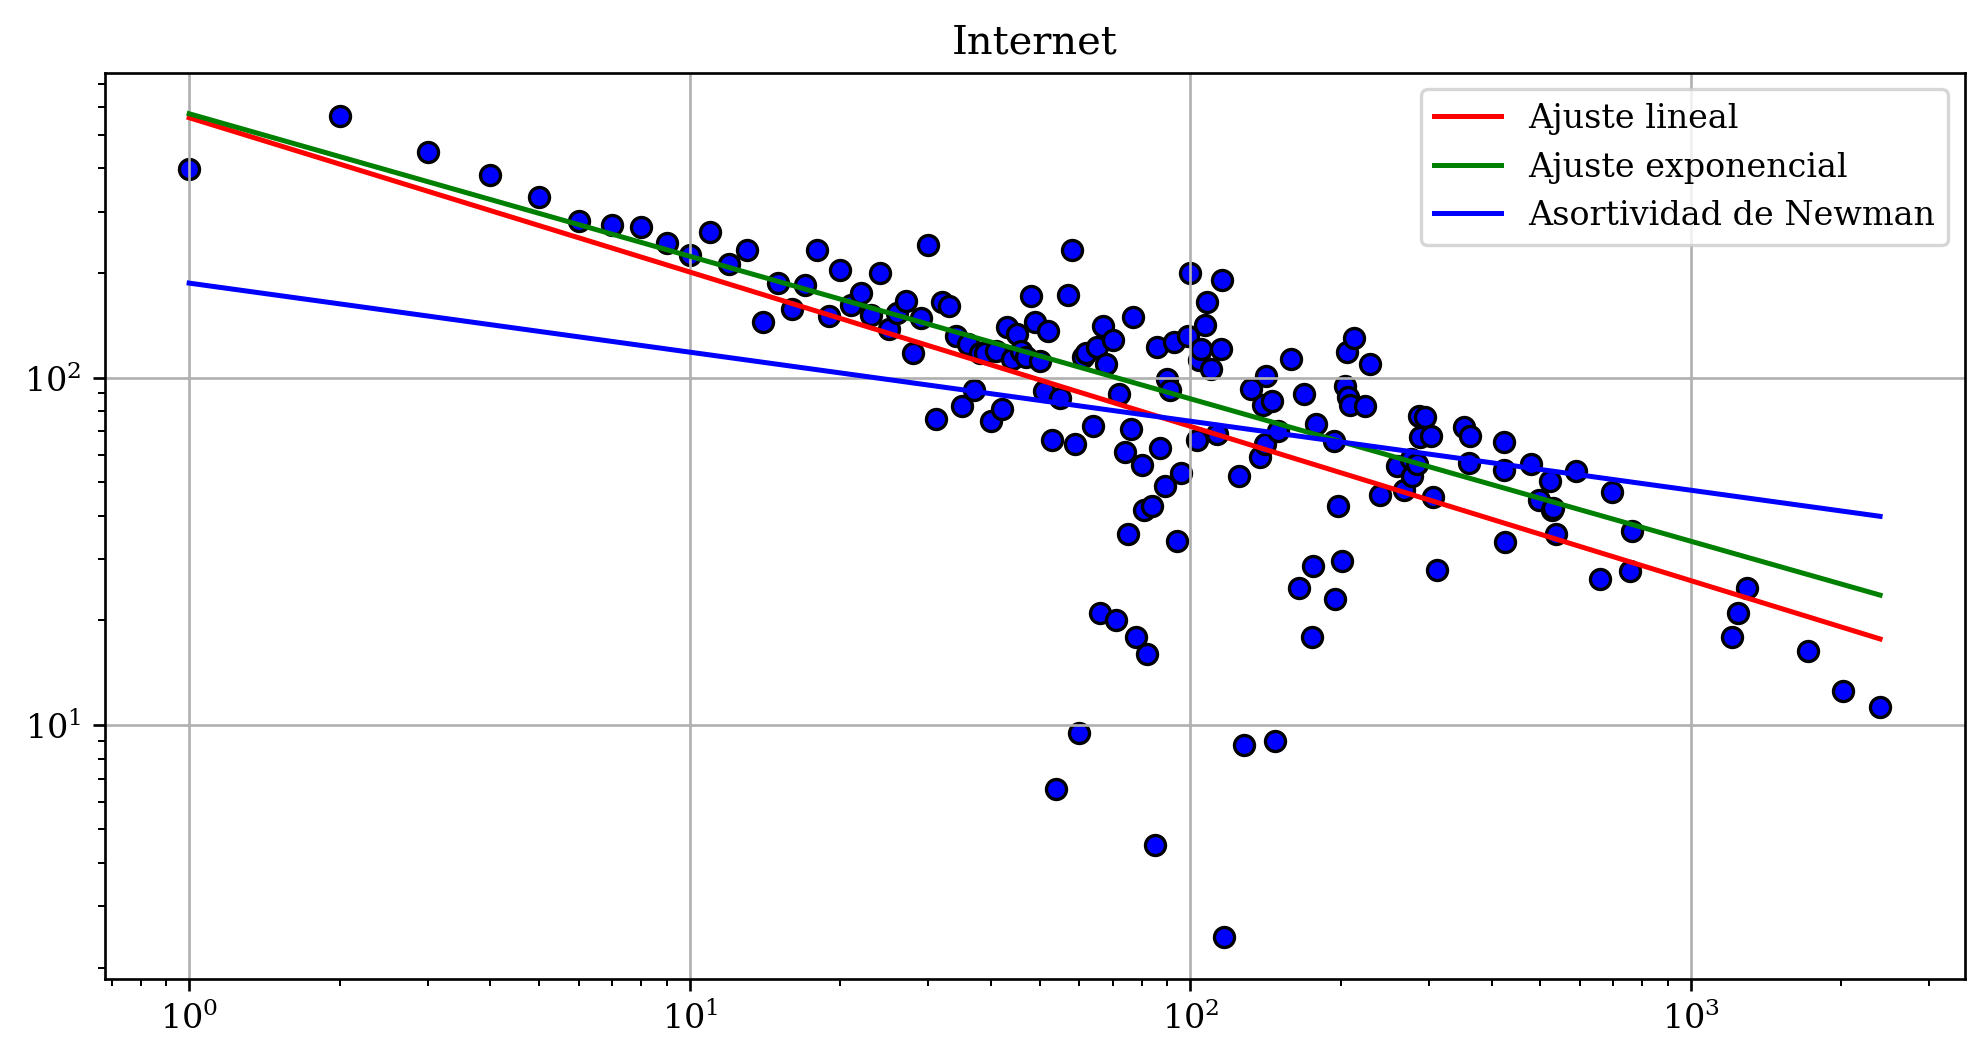

Parámetros óptimos del ajuste para la red 'Internet':
            alpha = -0.4442245203899384
            beta = 6.327758118600569
            a = 574.7189891279905
            mu = -0.4102068401813841
Asortatividad de Newman para la red 'internet': -0.19873552194552238


In [64]:
def analyze_asortivity(graph, title, newman_asortivity):
    knn_dict = nx.average_neighbor_degree(graph)
    k_dict = dict(nx.degree(graph))

    df = pd.DataFrame([k_dict, knn_dict]).T.rename(columns = {0: "k", 1: "knn"})
    df_grouped = df.groupby("k").mean().reset_index()
        
    k = np.array(df_grouped["k"])
    knn = np.array(df_grouped["knn"])
    
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    ax.scatter(k, knn, edgecolor="black", color="blue")
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    #Fit log(k_nn) vs log(k) por lineal
    lin = lambda x, alpha, beta: alpha*x + beta
    lin_fixed = lambda x, beta: newman_asortivity*x+beta
    popt_lin, pcov_lin = curve_fit(lin, np.log(k), np.log(knn))
    popt_fixed, pcov_fixed = curve_fit(lin_fixed, np.log(k), np.log(knn))
    
    alpha, beta = popt_lin
    beta_fixed = popt_fixed[0]
    
    #Fit log(k_nn) vs log(k) por exponencial
    exp = lambda x, a, mu: a*x**mu
    popt_exp, pcov_exp = curve_fit(exp, k, knn)
    a, mu = popt_exp

    k_smooth =  np.linspace(np.min(k), np.max(k), 100)
    ax.plot(k_smooth, np.exp(beta)*k_smooth**alpha, label="Ajuste lineal", color="red")
    ax.plot(k_smooth, a*k_smooth**mu, label="Ajuste exponencial", color="green")
    ax.plot(k_smooth, np.exp(beta_fixed)*k_smooth**newman_asortivity, label="Asortividad de Newman", color="blue")
    
    ax.set_title(title)
    ax.grid()
    
    plt.legend()
    plt.show()
            
    popt_dict = {"alpha": alpha, "beta": beta, "a": a, "mu": mu}
            
    print(f"""Parámetros óptimos del ajuste para la red '{title}':
            alpha = {popt_dict["alpha"]}
            beta = {popt_dict["beta"]}
            a = {popt_dict["a"]}
            mu = {popt_dict["mu"]}""")
    
    return fig, ax

def newman_asortivity(graph):
    """
    Cálculo de la asortividad de Newman dado un grafo.
    """
    nodes = list(graph.nodes())
    edges = list(graph.edges())
    degrees = dict(nx.degree(graph))
    degrees_arr = np.array(list(degrees.values()), dtype="int64")
    
    #Calculo de S1, S2, S3
    S1 = np.sum(degrees_arr)
    S2 = np.sum(degrees_arr**2)
    S3 = np.sum(degrees_arr**3)
    
    print(S1, S2, S3)
    
    #Calculo de Se
    Se = 0
    for e in edges:
        Se += degrees[e[0]]*degrees[e[1]] 
    Se *= 2
    
    #Finalmente sumamos los resultados según la formula para r.
    r = (S1*Se - S2**2)/(S1*S3 - S2**2)
    
    return r

n_asortivity_science = newman_asortivity(graph_science)
analyze_asortivity(graph_science, "Science", n_asortivity_science)
print(f"Asortatividad de Newman para la red 'science': {n_asortivity_science}\n", end = "\n"*2)

n_asortivity_internet = newman_asortivity(graph_internet)
analyze_asortivity(graph_internet, "Internet", n_asortivity_internet)
print(f"Asortatividad de Newman para la red 'internet': {n_asortivity_internet}")

**Nota**: En azul se gráfica un ajuste realizado fijando la pendiente por la asortatividad de Newman y permitiendo que la ordenada al origen varíe. De esta forma podemos comparar las pendientes.

Lo primero que se puede ver de los valores obtenidos para $\alpha$, $\mu$ y la asortatividad de Newman es que coinciden en sus signos en cada red. Además son de ordenes de magnitud similares (Menores que 1 en módulo).

Analizando la expresión para $r$ el coeficiente que se calcula, indica si los nodos de una red se unen a otros de caracteristicas similares (En este caso el grado). Repasando el procedimiento para realizar el ajuste, vemos que estamos calculando de otra forma un parámetro que espera cuantizar el mismo comportamiento de la red. Esto indica que lo mencionado en el primer párrafo es coherente.

No pudimos encontrar una razón por la que varía el módulo de $\alpha$ con respecto del $r$ en más del 50% para el caso de Internet, pero suponemos que está relacionado a los puntos que no parecen seguir la misma distribución (Se alejan de las recta de ajuste). Pondremos esto a prueba analizando también las redes Y2H y AP-MS.

Algo interesante de ver también es que para la red Science, utilizar como pendiente el valor de $r$ parece mejorar el ajuste si se varía la ordenada al origen de modo que coincida con las primeras mediciones.

## Repetimos para las redes Y2H y AP-MS

18140 630012 35881730


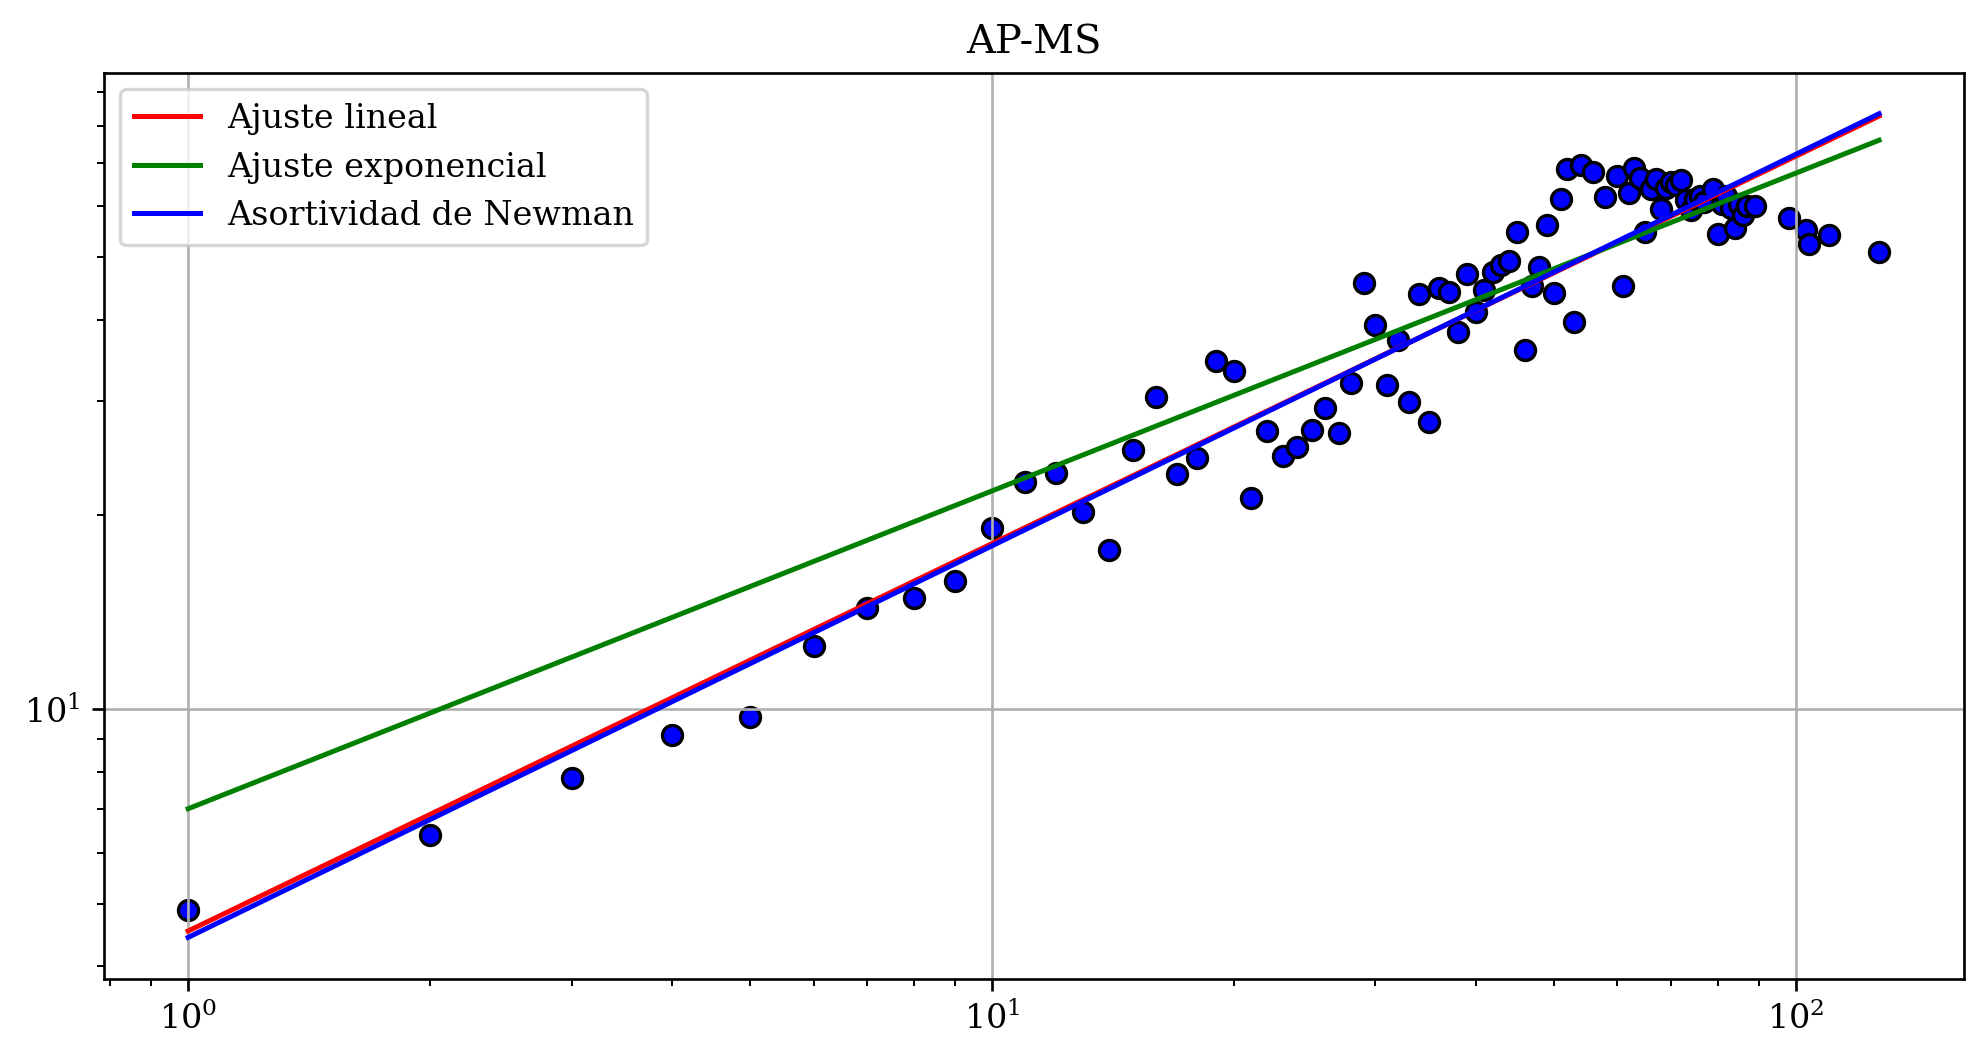

Parámetros óptimos del ajuste para la red 'AP-MS':
            alpha = 0.5992892363807953
            beta = 1.5125871150018013
            a = 7.016626062445684
            mu = 0.4915749901916193
Asortividad de Newman para la red 'AP-MS': 0.6056742188944484


5860 65112 2686954


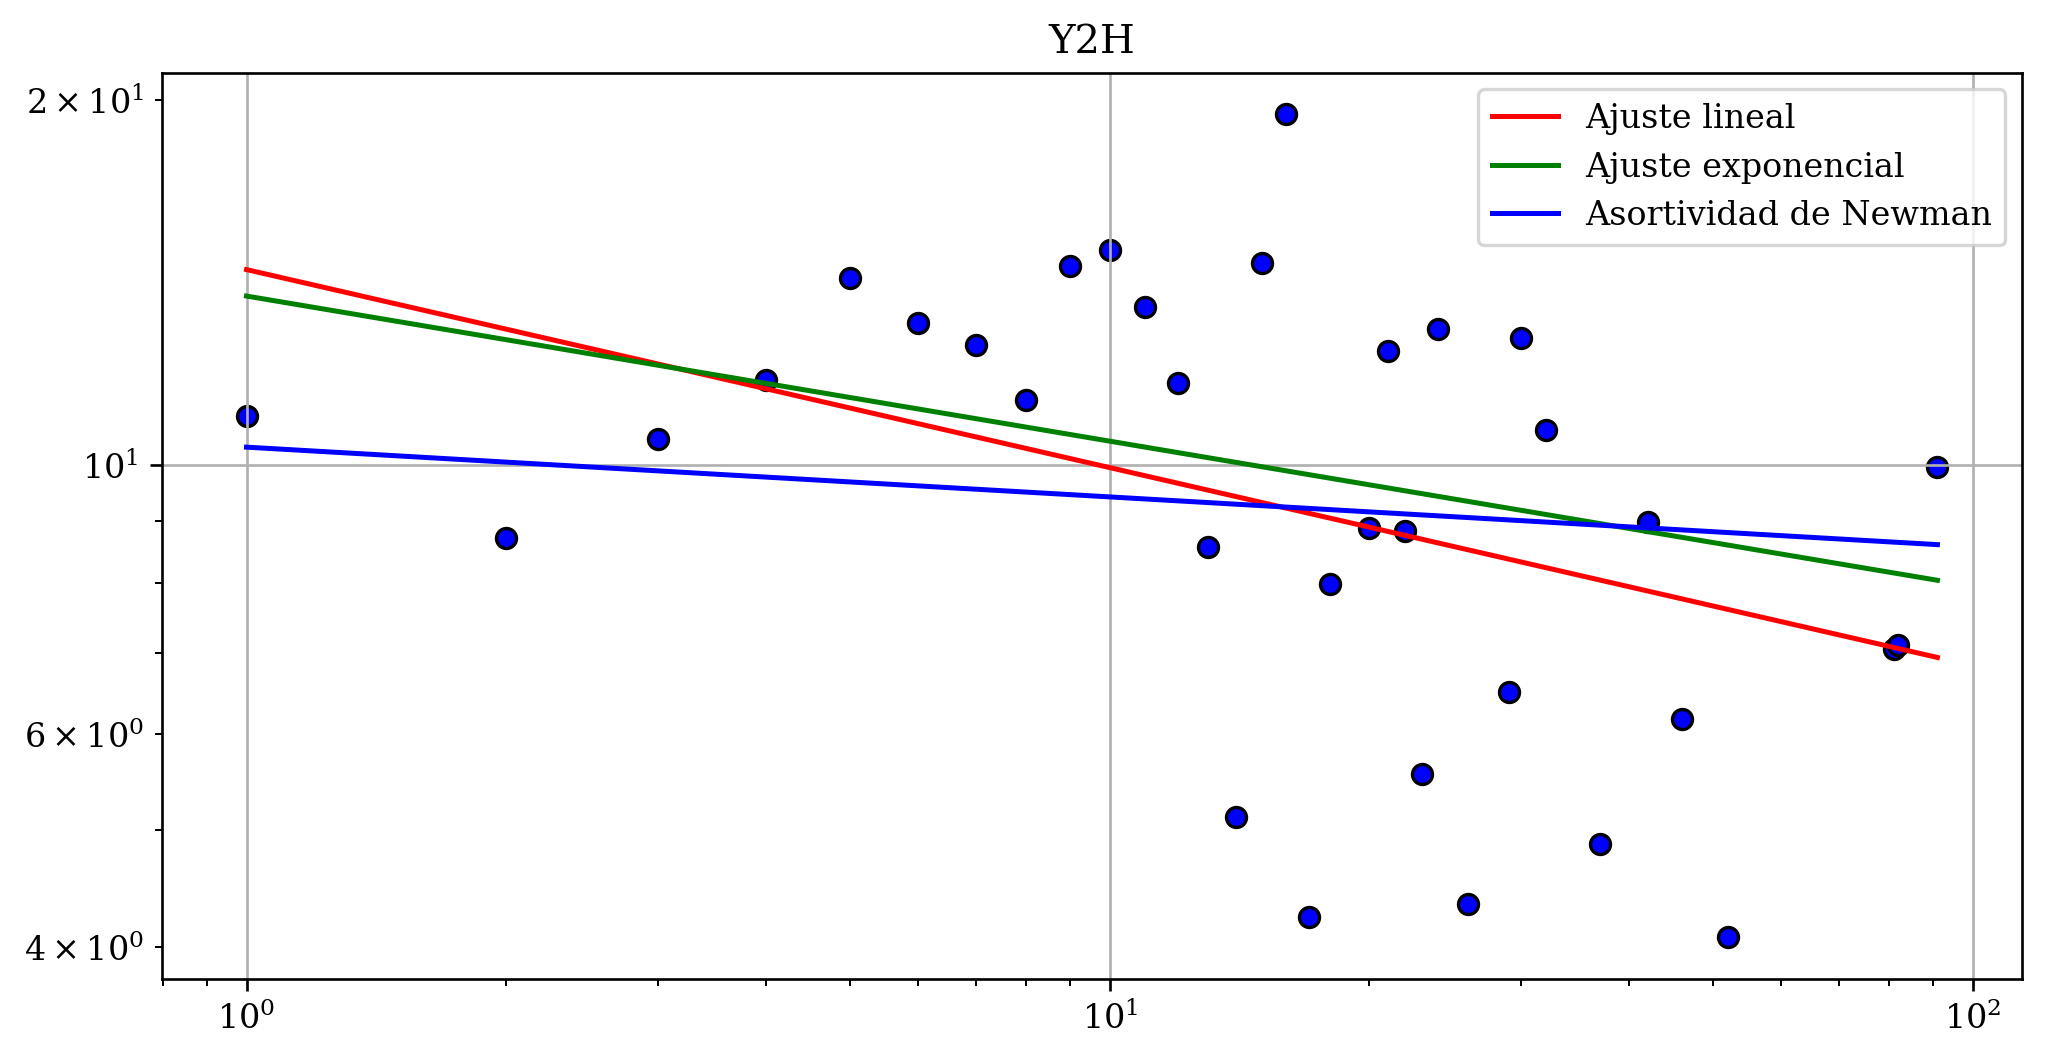

Parámetros óptimos del ajuste para la red 'Y2H':
            alpha = -0.16339360324501762
            beta = 2.674280239163515
            a = 13.790891122442847
            mu = -0.11974015575936459
Asortividad de Newman para la red 'Y2H': -0.041067211172400114


In [65]:
n_asortivity_apms = newman_asortivity(graph_apms)
analyze_asortivity(graph_apms, "AP-MS", n_asortivity_apms)
print(f"Asortividad de Newman para la red 'AP-MS': {n_asortivity_apms}", end="\n"*3)

n_asortivity_y2h = newman_asortivity(graph_y2h)
analyze_asortivity(graph_y2h, "Y2H", n_asortivity_y2h)
print(f"Asortividad de Newman para la red 'Y2H': {n_asortivity_y2h}")

Vemos que para AP-MS, que parece tener una menor desviación con respecto de las rectas que ajustan, los valores de $r$ y $\alpha$ son similares. Esto se hace aún mas notorio al comparar las rectas en el gráfico.

En Y2H sin embargo, vemos que la distribución de puntos no parece seguir una recta bien definida, y la diferencia entre $r$ y $\alpha$ se hacen más notorias.